In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import multinetx as mx
import csv, os
import matplotlib.pyplot as plt

In [2]:
def create_layer_from_csv(file_path, node_start_id = 0):
    """
    Creates a network layer from a csv file
    
    The first column in the csv file should hold names of nodes to be interconnected between layers
    
    Attributes
    ----------
    file_path : str
        a name of a csv file to process
    node_start_id : int
        first id to assign to a node created
        
    """
    
    G = nx.Graph()
    
    # first pass only creates the nodes with the appropriate bipartite attribute
    # bipartite = 0 is used for nodes to be interconnected between layers
    with open(file_path, encoding='utf8') as f:
        csv_reader = csv.reader(f)
        
        externally_connected = [] #what about duplicates are they to be expected?
        internally_connected = set()
        
        for row in csv_reader:
            externally_connected.append(row[0])
            internally_connected.add(row[1]) 
            
    G.add_nodes_from(externally_connected, bipartite=0)
    G.add_nodes_from(internally_connected, bipartite=1)
    
    # instead of forcing the bipatrite attribute like this we could possibly have done
    # nx.is_connected(G)
    # bottom_nodes, top_nodes = bipartite.sets(G)
    # possibly we could not be sure which set will be what A vs. B or B vs. A!
    
    # second pass creates a list of edges.
    # not sure which is better; reset the csv_reader or just create a new one, taking the latter option
    with open(file_path, encoding='utf8') as f:
        csv_reader = csv.reader(f)
        # get the data as list of tuple
        edges = [(row[0], row[1]) for row in csv_reader]
        
    G.add_edges_from(edges)
    
    # haven't still succeeded in triggering this exception, the way I'm assigning the bipartite attribude acc. to columns
    # in the csv, always creates a new node if trying that. 
    if not bipartite.is_bipartite(G):
        raise Exception('Network is not bipartite')
        
    # abandon labels for ids, here we are using the default value for the ordering parameter
    return nx.convert_node_labels_to_integers(G, first_label=node_start_id, ordering='default', label_attribute='name') #, externally_connected


In [3]:
def get_current_count_of_nodes(layers):
    """
    Returns the total count of nodes in list/collection/iterable! of networkX layers 
    
    """
    
    node_count = 0
    
    for layer in layers:
        node_count += layer.number_of_nodes()
        
    return node_count

In [4]:
def get_interconnect_nodes(layers):
    """
    Extracts the sets on nodes to be interconnected
    
    """
    
    sets = []
    
    for layer in layers:
        sets.append({n for n, d in layer.nodes(data=True) if d['bipartite']==0})
        
    return sets

In [5]:
def wire_interconnections(layers, interconnect_nodes):
    """
    Retruns a descriptive datastrcuture (a dict of lists) describing how the nodes are to be interconnected
    
    Attributes
    ----------
    layers : list
        list of networkX graphs
    interconnect_nodes : list
        contents of the list are sets of nodes to be interconnected in each layer
    
    """
    
    interconnect_nodes_by_name = {}
    
    for n,interconnect_set in enumerate(interconnect_nodes):
        for node_id in interconnect_set:
            
            name = layers[n].nodes[node_id]['name']
            
            if name not in interconnect_nodes_by_name:
                interconnect_nodes_by_name[name] = [node_id]
            else:
                interconnect_nodes_by_name[name].append(node_id)
            
    return interconnect_nodes_by_name

In [6]:
# where are the csv files located, relative to the current folder where his script is run
directory = '.'

layers = []

for f in os.listdir(directory):

    # if other files than csv are present, skip those
    if f[-4:] != '.csv':
        continue
        
    file_path = os.path.join(directory, f)

    layers.append(create_layer_from_csv(file_path, get_current_count_of_nodes(layers)))
    
interconnect_nodes = get_interconnect_nodes(layers)
interconnections = wire_interconnections(layers, interconnect_nodes)

N = get_current_count_of_nodes(layers) # not efficient bot ok for now

adj_block = mx.lil_matrix(np.zeros((N, N)))

for indices in interconnections.values():

    # it might happen that a node to interconnect appears only on one layer
    if len(indices) == 1:
        continue
        
    pos = 0
    
    # if we have more than 2 layers the we want to process them all
    while (pos+2) <= len(indices):
        
        adj_block[indices[pos],indices[pos+1]] = 1
        
        pos += 1
    
adj_block += adj_block.T

In [7]:
print(adj_block)

  (0, 23)	1.0
  (1, 22)	1.0
  (2, 19)	1.0
  (3, 28)	1.0
  (4, 16)	1.0
  (5, 29)	1.0
  (6, 18)	1.0
  (7, 27)	1.0
  (8, 24)	1.0
  (9, 21)	1.0
  (10, 26)	1.0
  (11, 25)	1.0
  (12, 20)	1.0
  (13, 17)	1.0
  (16, 4)	1.0
  (17, 13)	1.0
  (18, 6)	1.0
  (19, 2)	1.0
  (20, 12)	1.0
  (21, 9)	1.0
  (22, 1)	1.0
  (23, 0)	1.0
  (24, 8)	1.0
  (25, 11)	1.0
  (26, 10)	1.0
  (27, 7)	1.0
  (28, 3)	1.0
  (29, 5)	1.0


In [8]:
# just for debugging purposes!
#layers[0].nodes(data=True)

In [9]:
# just for debugging purposes!
#layers[1].nodes(data=True)

In [10]:
mg = mx.MultilayerGraph(list_of_layers=layers, inter_adjacency_matrix=adj_block)
# next two lines gives an error!
#mg.add_layer(g_loc)
#mg.add_layer(g_disc)

# mg.layers_interconnect(inter_adjacency_matrix=adj_block)
# this should also be possible thrugh a named parameter to the constructor:

# mx.MultilayerGraph(list_of_layers=[g1,g2,g3], inter_adjacency_matrix=adj_block)

In [11]:
# just to be aple to plot someting below...

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=3)

# this below gives an error on the weights when plotting!
#mg.set_edges_weights(inter_layer_edges_weight=3)

#mg.set_intra_edges_weights(layer=0,weight=1)
#mg.set_intra_edges_weights(layer=1,weight=2)

c:\program files\python36\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\program files\python36\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
c:\program files\python36\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


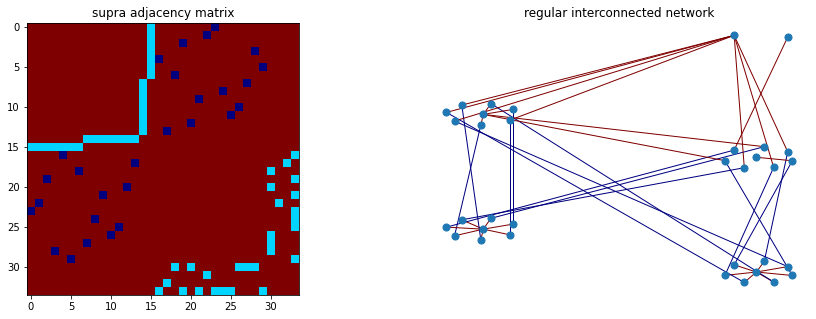

In [12]:
# this block from here:
# https://github.com/nkoub/multinetx#plot-the-adjacency-matrix-and-the-multiplex-networks-2

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('regular interconnected network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(mg.get_layer(0)),layer_vertical_shift=1.4,layer_horizontal_shift=0.0,proj_angle=7)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],edge_cmap=plt.cm.jet_r)
plt.show()